# tSNE analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.manifold import TSNE
from scipy import linalg
from numpy.random import default_rng
import time
import nibabel as nb
import cortex
import os
file_store = cortex.options.config.get('basic', 'filestore')
file_path = os.path.join(file_store, 'fsaverage', 'overlays.svg')

In [2]:
log_dir = "/home/hpcgies1/rds/hpc-work/NIC/Log/"

In [3]:
"""
Load Glasser data
"""

GLASSER_LH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/lh.HCP_MMP1.mgz"
GLASSER_RH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/rh.HCP_MMP1.mgz"
s = time.time()
glasser_lh = nb.load(GLASSER_LH).get_fdata() # 163_842 values in the range [0, 180]
glasser_rh = nb.load(GLASSER_RH).get_fdata()
print(f"load glasser masks: {(time.time() - s):.2f}")

glasser = np.vstack((glasser_lh, glasser_rh)).flatten()

print("glasser_lh", glasser_lh.shape)
print("glasser_rh", glasser_rh.shape)
print("glasser   ", glasser.shape)

glasser_lh_flat = glasser_lh.flatten()
glasser_rh_flat = glasser_rh.flatten()
glasser_indices_rh = np.array(range(len(glasser_rh_flat)))
groups_rh = []
for i in set(glasser_rh_flat):
    groups_rh.append(glasser_indices_rh[glasser_rh_flat == i])
glasser_indices_lh = np.array(range(len(glasser_lh_flat)))
groups_lh = []
for i in set(glasser_rh_flat):
    groups_lh.append(glasser_indices_lh[glasser_lh_flat == i])
    
# groups = groups_lh[1:] + groups_rh[1:]   # Uncomment to remove the 0'th region
groups = groups_lh + groups_rh

#groups_concat = list(map(list.__add__, groups_lh, groups_rh))
# groups_lh = groups_lh[1:]
# groups_rh = groups_rh[1:]
# assert len(groups) == 360, "Using separate hemishere groups = 360"


load glasser masks: 0.13
glasser_lh (163842, 1, 1)
glasser_rh (163842, 1, 1)
glasser    (327684,)


In [4]:
print(len(groups))

362


## Data Loading & Plotting functions

In [5]:
def get_flatmap(glasser_regions):
    cortex.add_roi
    vert = cortex.Vertex(glasser_regions, subject='fsaverage')#, vmin=-8, vmax=8)
    im, extents = cortex.quickflat.make_flatmap_image(vert)
    return im, extents


def generate_plot(data_):
    """ Generate the glasser_regions which can be converted to flatmap and plotted 
    Parameters
    ----------
        data : np.array - 1-D  (360,)
    """
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    glasser_regions_lh[:] = np.NaN
    glasser_regions_rh[:] = np.NaN
    for i, g in enumerate(groups_lh[1:]):
        glasser_regions_lh[g] = data_[i]
    for i, g in enumerate(groups_rh[1:]):
        glasser_regions_rh[g] = data_[i+180]
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)
    return glasser_regions

def load_attn(file_path):
    return np.squeeze(np.load(file_path), axis=-1)

def get_attn_file(model_name):
    files = glob.glob(f"{log_dir}/{model_name}/eval_out/attention_*")
    print(model_name, "--", files[0].split("/")[-1])
    return files[0]

def normalise_(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [6]:
all_subs = load_attn(get_attn_file("torch_alt_batches"))
sub1_indv = load_attn(get_attn_file("subject_1_layer_norm"))

torch_alt_batches -- attention_scores_8.npy
subject_1_layer_norm -- attention_scores_28.npy


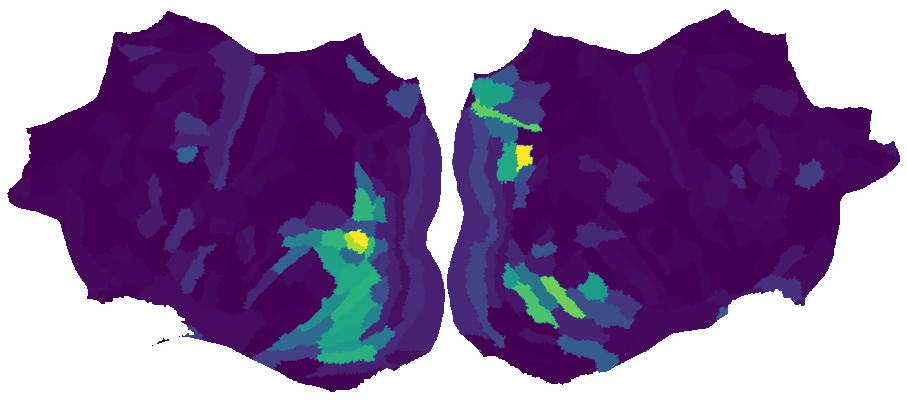

1.0
0.0


In [7]:
plt.figure(figsize=(16,9))
d = np.mean(all_subs[6], axis=(0,1))
d = (d - np.min(d)) / (np.max(d) - np.min(d))
plt.imshow(get_flatmap(generate_plot(d))[0])
plt.axis('off')
plt.show()

print(np.max(d))
print(np.min(d))

In [13]:
# all_subs = np.mean(all_subs, axis=(1,2))
all_subs_flat = all_subs.reshape(-1, 360)
all_subs_flat.shape

(61800, 360)

In [198]:
def tsne(data):
    X = TSNE(
        n_components=2, 
        perplexity=5, 
        init='random',#'pca', 
        learning_rate='auto', 
        n_jobs=-1).fit_transform(data)
    print("tSNE out:", X.shape)
    return X

In [18]:
dddd

/home/hpcgies1/.conda/envs/pycor2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/hpcgies1/.conda/envs/pycor2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


tSNE out: (61800, 2)


### Subject 2

In [199]:
all_subs_2 = all_subs[1].reshape(-1, 360)
print(all_subs_2.shape)
X_sub2 = tsne(all_subs_2)

(7725, 360)
tSNE out: (7725, 2)


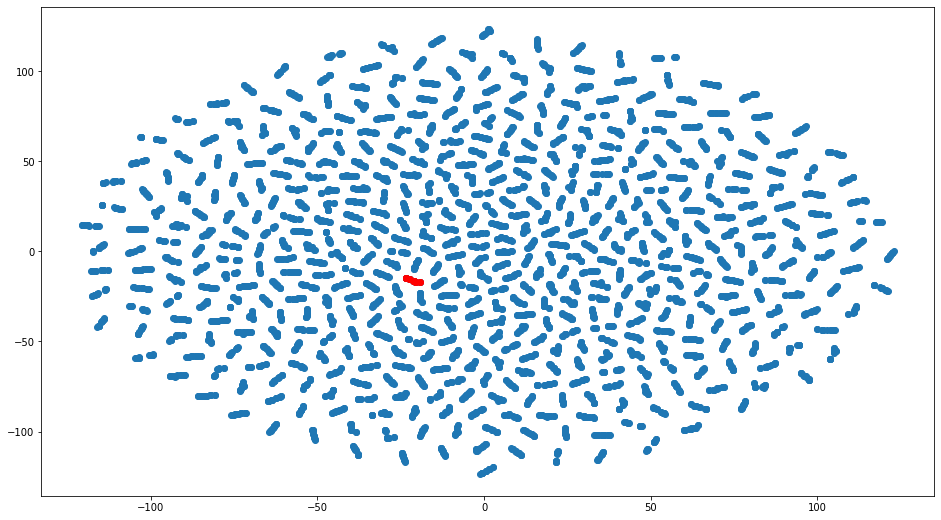

In [209]:
plt.figure(figsize=(16,9))
plt.scatter(X_sub2[:,0], X_sub2[:,1])
X_sub2_ = X_sub2.reshape(515, 15, 2)

# Mask certain timesteps/trials
trial = 0
timestep = 0
plt.scatter(X_sub2_[trial,:,0], X_sub2_[trial,:,1], color='r')

plt.show()

### Indv. sub

In [222]:
# sub1_indv.shape
sub1_indv = np.squeeze(np.load("/home/hpcgies1/Masters-Thesis/AttemptFour/Log/subject_2_baseline2/eval_out/attention_scores_80.npy"),-1)
sub1_f = sub1_indv.reshape(-1, 360)
X_sub1_f = tsne(sub1_f)

tSNE out: (7725, 2)


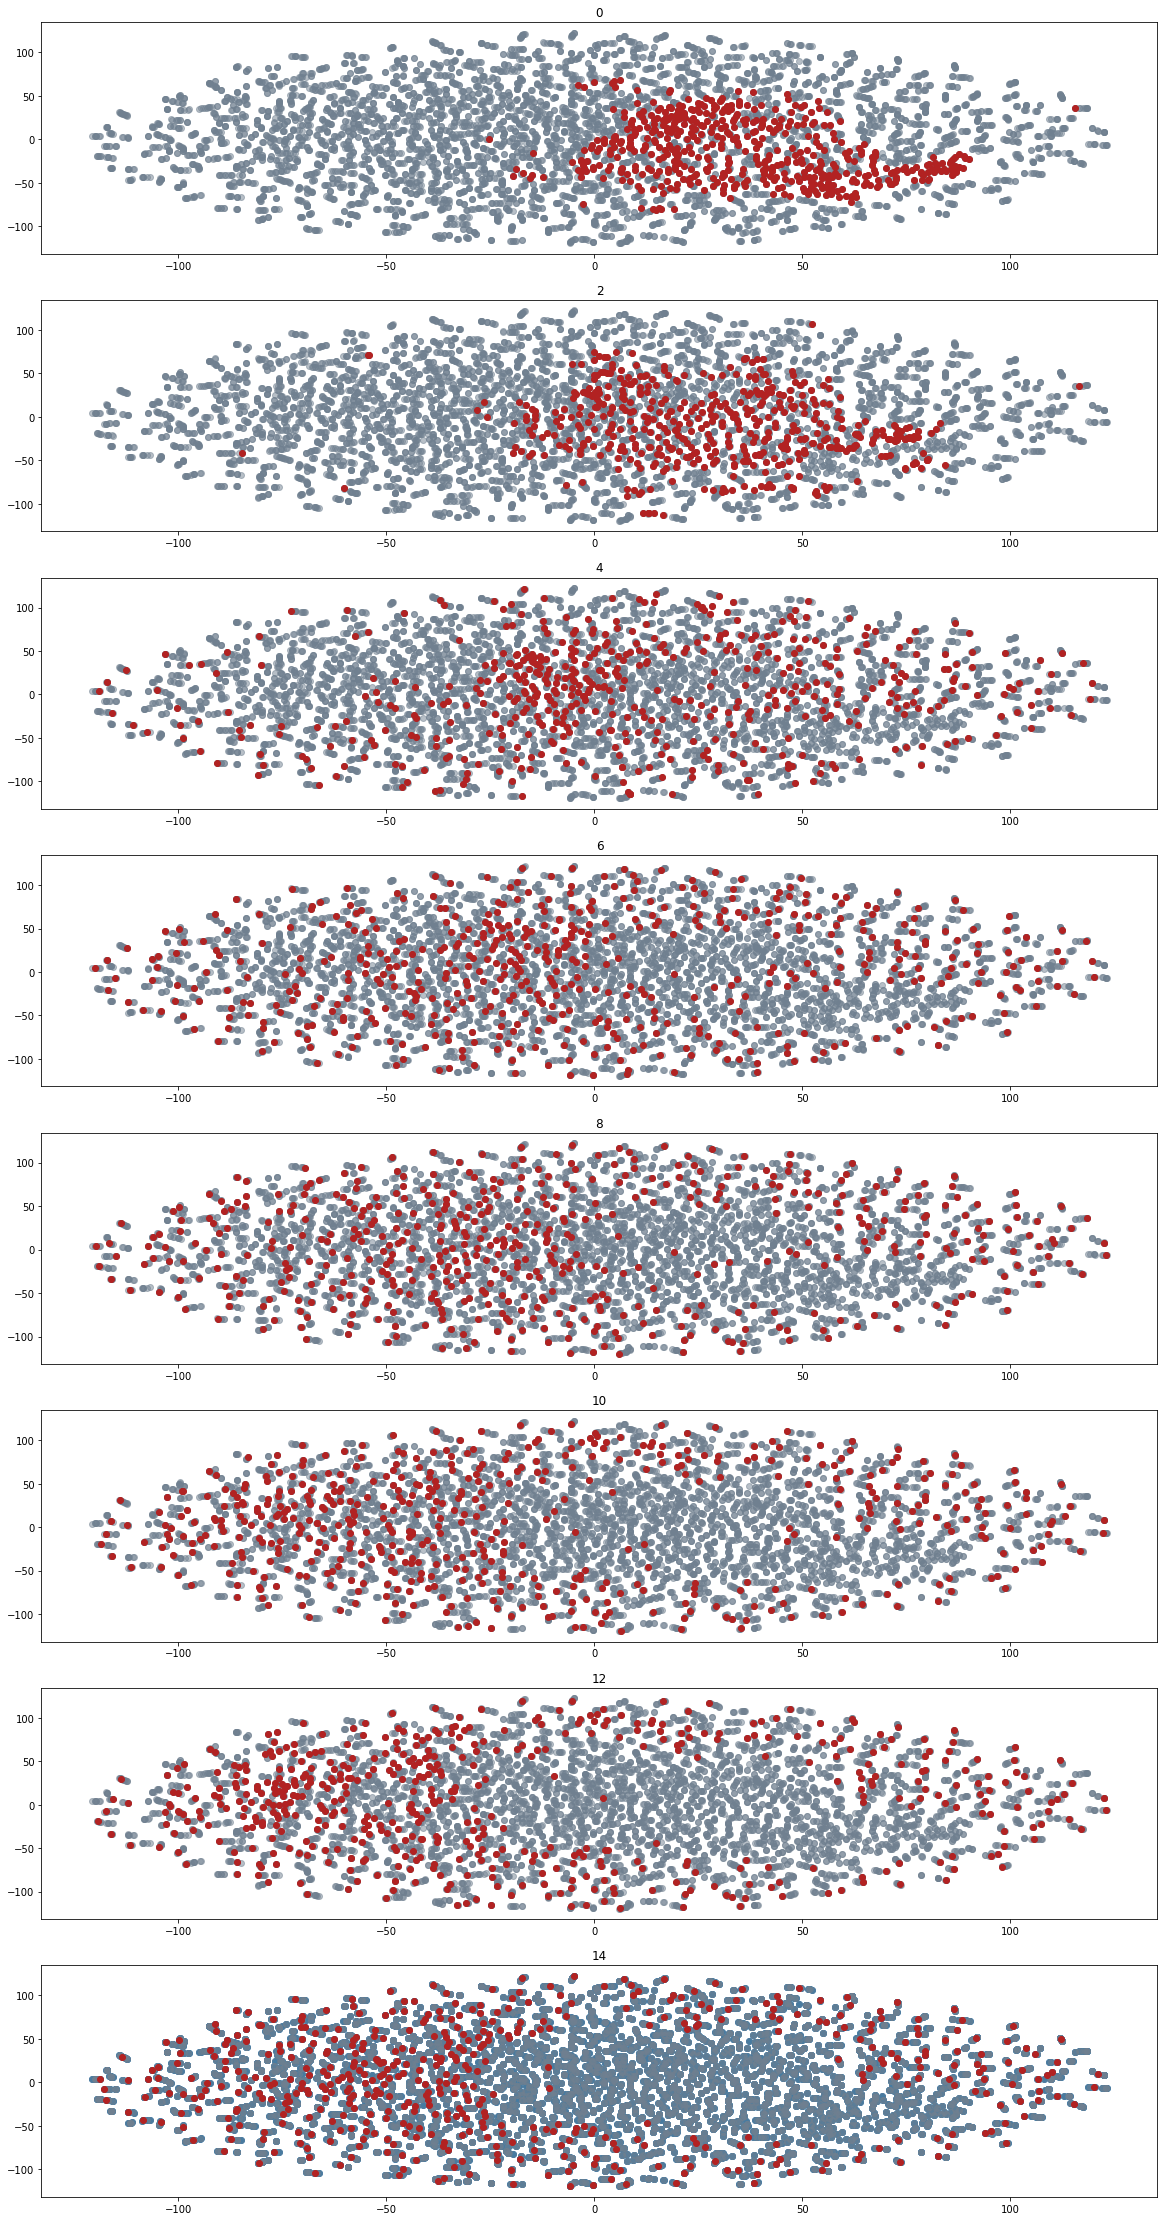

In [223]:
fig, ax = plt.subplots(8,1, figsize=(20,40))
plt.scatter(X_sub1_f[:,0], X_sub1_f[:,1])
X_sub1_f_ = X_sub1_f.reshape(515, 15, 2)

# trial = 0
# timestep = 0
# plt.scatter(X_sub1_f[trial,:,0], X_sub1_f[trial,:,1], color='r')

x,y,z = X_sub1_f_.shape
# ii = X_sub1_f[list(range(0, x*y, 15)),0]
# kk = X_sub1_f[list(range(0, x*y, 15)),0]
ii = 0
for i in range(0, 15, 2):
    pos = list(range(i, x*y, 15))
    ax[ii].scatter(X_sub1_f[:,0], X_sub1_f[:,1], color='slategray', alpha=0.5)
    ax[ii].scatter(X_sub1_f[pos,0], X_sub1_f[pos,1], color='firebrick')
    ax[ii].set_title(f"{i}")
    ii += 1


plt.show()

### All subjects 

In [ ]:
X = tsne(all_subs_flat)


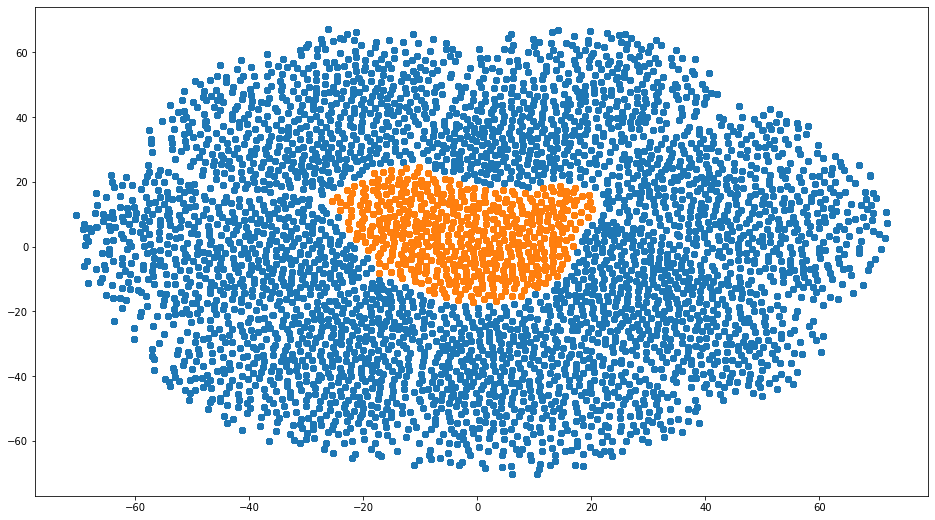

In [22]:

plt.figure(figsize=(16,9))
plt.scatter(X[:,0], X[:,1])

plt.scatter(X[:515*15,0], X[:515*15,1])

In [ ]:
X_sub2 = tsne

## Variance across time

In [165]:
sub2 = sub1_indv
sub2_var = np.std(all_subs[1], axis=-1)
sub2_var.shape

# sub2_var = np.mean(sub2_var, axis=0)

sub2_var.shape
for i in 

(515, 15)

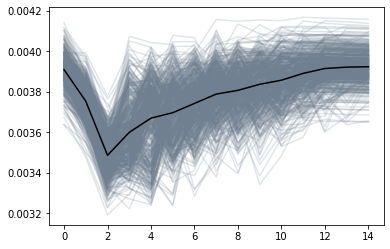

In [166]:
sub2 = sub1_indv
sub2_var = np.std(sub2, axis=-1)
sub2_var.shape

# sub2_var = np.mean(sub2_var, axis=0)

for i in range(sub2_var.shape[0]):
    plt.plot(sub2_var[i], color='slategray', alpha=0.2)

plt.plot(np.mean(sub2_var, axis=0), color='k')

plt.show()

## SVD

In [137]:
Xt = np.mean(all_subs[1], axis=1
            )
print(Xt.shape)
# Xt = np.mean(all_subs, axis=(0,2))
# print(Xt.shape)

start = time.time()
U, s, Vh = linalg.svd(Xt)
print(f"{(time.time() - start):.3f}")

(515, 360)
0.049


In [138]:
print(U.shape)
print(s.shape)
print(Vh.shape)

var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(var_explained[:10])

num_components = 0
reconst_img = np.matrix(U[:, [num_components]]) * np.diag(s[[num_components]]) * np.matrix(Vh[[num_components], :])
reconst_img = np.array(reconst_img)
print(reconst_img.shape)

(515, 515)
(360,)
(360, 360)
[0.589 0.057 0.025 0.021 0.016 0.014 0.014 0.013 0.012 0.011]
(515, 360)


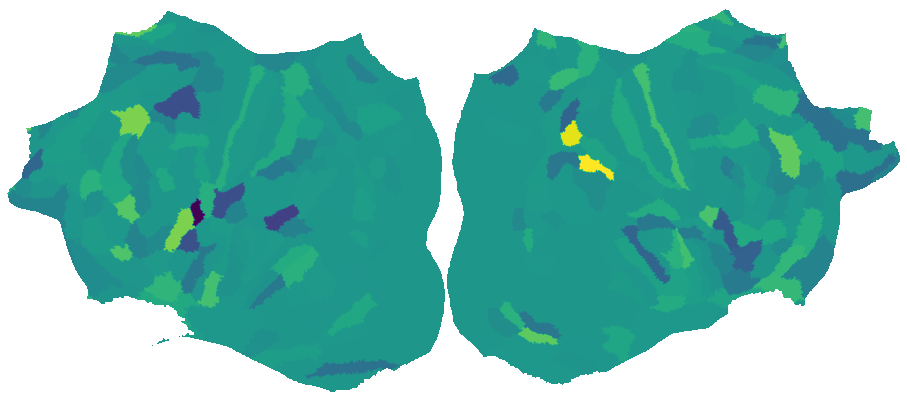

In [323]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
plt.imshow(get_flatmap(generate_plot(reconst_img[0]))[0], cmap='viridis')
plt.axis('off')
plt.show()

# 3D plots

In [401]:
volume = cortex.Volume.random(subject='fsaverage', xfmname='atlas_3mm')
vx, vy, vz = volume.shape
print("volume:", volume.shape)
print( vx * vy * vz )
# left and right hemi : 163_842


volume: (51, 60, 53)
162180


In [429]:
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf('fsaverage', "fiducial")]
num_verts = [s.pts.shape[0] for s in surfs]
print(num_verts)

test1 = np.hstack((np.arange(num_verts[0]), np.arange(num_verts[1])))
temp = cortex.Vertex(test1, 'fsaverage')
# dir(temp)
print(np.max(test1))
print(np.min(test1))
print(temp.vmax)
print(temp.vmin)
# temp.data.shape
# temp = temp.volume('atlas')

[163842, 163842]
163841
0
162203.0
1638.0


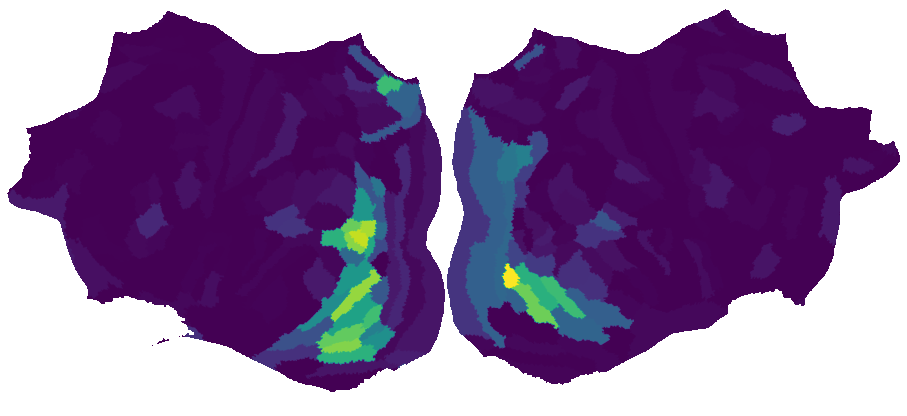

In [8]:
d = np.mean(all_subs[1], axis=(0,1))

plt.figure(figsize=(16,9))
plt.axis('off')
d = generate_plot(d)
plt.imshow(get_flatmap(d)[0])
plt.show()

d = cortex.Vertex(d, 'fsaverage')

# select path for static viewer on disk
viewer_path = './outputs/'

# create viewer
# cortex.webgl.make_static(outpath=viewer_path, data=d, recache=False)


/home/hpcgies1/.conda/envs/pycor2/lib/python3.8/site-packages/cortex/dataset/braindata.py:487: UserWarning: Inverse mapping cannot be accurate
  warnings.warn('Inverse mapping cannot be accurate')


0.3246483206520317 0.0
1.0 0.0


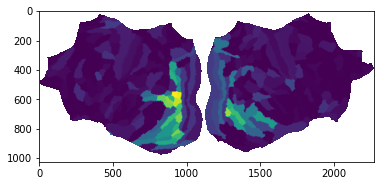

In [9]:
# temp = normalise_(np.mean(all_subs[1], axis=(0,1)))
# print(np.min(temp), np.max(temp))
# temp = generate_plot(temp)
# temp = cortex.Vertex(temp, 'fsaverage')
# temp = temp.volume('atlas')
# print("sub:", temp.shape)

d = np.mean(all_subs[3], axis=(0,1))

d = (d - np.min(d)) / (np.max(d) - np.min(d))
plt.imshow(get_flatmap(generate_plot(d))[0])

normalise_ = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

def generate_3d(x):
    """ Takes (360,) attention data """
#     x = normalise_(x)
    x = generate_plot(x)
    x = cortex.Vertex(x, 'fsaverage', vmin=0, vmax=1)
    x = x.volume('atlas_3mm')
    return x

temp = generate_3d(d)

print(temp.vmax, temp.vmin)

print(np.max(d), np.min(d))

In [10]:
xx = cortex.webgl.show(data=temp, autoclose=True, port=49840, cmap='viridis')


Started server on port 49840
   Loading data...
